## Process shadow tomography

Related papers [Kunjummen et al, Phys. Rev. A 107, 042403 (2023)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.107.042403), 
  [Levy,et al Phys. Rev. Research 2024](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.6.013029), 

  For common randomized measurements, we also use [Vermersch, al, PRXQ 2024](https://doi.org/10.1103/PRXQuantum.5.010352)

In [1]:
using ProgressMeter
using ITensors
using RandomMeas

In [2]:
N = 2
depth = 2
ξ = siteinds("Qubit", N;addtags="output")
s = siteinds("Qubit", N;addtags="input")

#Create a Bell-State density matrix with an ancilla space to compute the choi Matrix
ρ0 = MPO(ξ)
for i in 1:N
    ρ0[i] = δ(s[i],ξ[i])*δ(s[i]',ξ[i]')
end

circuit    = random_circuit(ξ, depth)
Λ0 = apply(circuit,ρ0,apply_dag=true);

p  = 0.1*rand(N)
Λ = apply_depo_channel(Λ0,p)

F = real(inner(Λ,Λ0)/4^N)
println(" -- Process Fidelity ", F)

 -- Process Fidelity 0.9242817711756479


In [3]:
nu = 4000
NM = 10000
states = ["Dn" for n in 1:N]
ψ  = MPS(ComplexF64,ξ,states)
ρ = outer(ψ',ψ)
data = zeros(Int8,(NM,N))
shadow = ITensor(vcat(ξ,ξ'))
Λs = ITensor(vcat(ξ,ξ',s,s'))
Λs_CRM = ITensor(vcat(ξ,ξ',s,s'))

P0 = state(s[1],"Dn")
for i in 2:N
    P0 *= state(s[i],"Dn")
end

Fs = zeros(Float64,nu)
Fs_CRM = zeros(Float64,nu)

@showprogress dt=1 for r in 1:nu   
        ui = get_rotations(ξ,1) #Haar rotations in A
        uf = get_rotations(ξ,1) #Haar rotations in A
        ### Quantum Measurements
        ρu = apply(ui,ρ,apply_dag=true)
        ρe = apply(circuit,ρu,apply_dag=true)
        ρen = apply_depo_channel(ρe,p)

        #Build shadow for the initial state
        uid = [dag(ui[i])*δ(s[i],ξ[i]')*δ(s[i]',ξ[i]) for i in 1:N]
        ρi = get_shadow(P0,s,uid)
        ρi = swapinds(ρi,s,s')

        #Build shadow for the final state
        data = get_RandomMeas(ρen,uf,NM)
        P = get_Born(data,ξ)
        ρf = get_shadow(P,ξ,uf)

        #Form process shadow
        Λt = 2^N*ρi*ρf
        Λs += Λt
        Fs[r] = real(inner(Λs,flatten(Λ0))/2^(2*N))/r
    
         Pσ = get_Born(apply(uf,ρe,apply_dag=true))
         σf = get_shadow(Pσ,ξ,uf)
         Λt_CRM = Λt-2^N*ρi*σf+flatten(Λ0)
         Λs_CRM += Λt_CRM
         Fs_CRM[r] = real(inner(Λs_CRM,flatten(Λ0))/2^(2*N))/r
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:49K


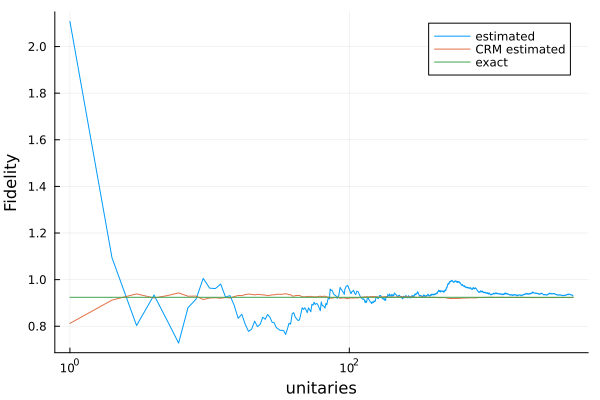

In [4]:
using Plots
plot(1:nu,Fs,label="estimated", xscale=:log10)
plot!(1:nu,Fs_CRM,label="CRM estimated")
plot!(1:nu,F*ones(nu),label="exact")

ylabel!("Fidelity")
xlabel!("unitaries")